
# Predicción de **total_UPDRS** (Parkinsons Telemonitoring – UCI)


> **Dataset:** *Parkinsons Telemonitoring Data Set* (UCI). Target: **`total_UPDRS`**.


## 1. Carga de librerías y datos

In [5]:

# --- Configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
df = pd.read_csv("parkinsons_updrs.data")

print("Forma del dataset:", df.shape)
df.head()


Forma del dataset: (5875, 22)


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


## 2. Selección de variables predictoras y target

In [ ]:


feature_names = [
    "age", "test_time",
    "Jitter(%)","Jitter(Abs)","Jitter:RAP","Jitter:PPQ5","Jitter:DDP",
    "Shimmer","Shimmer(dB)","Shimmer:APQ3","Shimmer:APQ5","Shimmer:APQ11",
    "Shimmer:DDA","NHR","HNR","RPDE","DFA","PPE","sex"
]
target_name = "total_UPDRS"


feature_names = [c for c in feature_names if c in df.columns]

X = df[feature_names].copy()
y = df[target_name].copy()

print("Características usadas:", len(feature_names))
print(feature_names)
print("Target:", target_name)


Características usadas: 19
['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex']
Target: total_UPDRS


## 3. Modelo lineal + validación cruzada

In [8]:

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
lin_reg = LinearRegression()
dummy = DummyRegressor(strategy="mean")

scoring_rmse = make_scorer(lambda yt, yp: mean_squared_error(yt, yp, squared=False))
scoring_mae = make_scorer(mean_absolute_error)
scoring_r2 = make_scorer(r2_score)

scores_rmse = cross_val_score(lin_reg, X, y, cv=cv, scoring="neg_root_mean_squared_error")
scores_mae  = cross_val_score(lin_reg, X, y, cv=cv, scoring="neg_mean_absolute_error")
scores_r2   = cross_val_score(lin_reg, X, y, cv=cv, scoring="r2")

print("Regresión Lineal - 5-CV")
print("RMSE (promedio ± std): %.3f ± %.3f" % (-scores_rmse.mean(), scores_rmse.std()))
print("MAE  (promedio ± std): %.3f ± %.3f" % (-scores_mae.mean(), scores_mae.std()))
print("R^2  (promedio ± std): %.3f ± %.3f" % (scores_r2.mean(), scores_r2.std()))

scores_rmse_dummy = cross_val_score(dummy, X, y, cv=cv, scoring="neg_root_mean_squared_error")
scores_r2_dummy   = cross_val_score(dummy, X, y, cv=cv, scoring="r2")

print("\nBaseline DummyRegressor - 5-CV")
print("RMSE (promedio ± std): %.3f ± %.3f" % (-scores_rmse_dummy.mean(), scores_rmse_dummy.std()))
print("R^2  (promedio ± std): %.3f ± %.3f" % (scores_r2_dummy.mean(), scores_r2_dummy.std()))


Regresión Lineal - 5-CV
RMSE (promedio ± std): 9.745 ± 0.277
MAE  (promedio ± std): 8.074 ± 0.232
R^2  (promedio ± std): 0.170 ± 0.023

Baseline DummyRegressor - 5-CV
RMSE (promedio ± std): 10.699 ± 0.177
R^2  (promedio ± std): -0.001 ± 0.000


## 4. Selección de características (Forward SFS)

In [ ]:

best_score = np.inf
best_k = None
best_features = None

for k in range(1, len(feature_names)):
    sfs = SequentialFeatureSelector(
        estimator=LinearRegression(),
        n_features_to_select=k,
        direction="forward",
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=None
    )
    sfs.fit(X, y)
   
    score = -sfs.get_support(indices=True).shape[0]  

    mask = sfs.get_support()
    X_sel = X.loc[:, mask]
    rmse_cv = -cross_val_score(LinearRegression(), X_sel, y, cv=cv, scoring="neg_root_mean_squared_error").mean()
    if rmse_cv < best_score:
        best_score = rmse_cv
        best_k = k
        best_features = list(X_sel.columns)

print(f"Mejor k (número de variables): {best_k}")
print(f"RMSE CV con k óptimo: {best_score:.3f}")
print("Variables seleccionadas:")
print(best_features)


Mejor k (número de variables): 12
RMSE CV con k óptimo: 9.736
Variables seleccionadas:
['age', 'test_time', 'Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer:APQ3', 'Shimmer:APQ11', 'NHR', 'HNR', 'DFA', 'PPE', 'sex']


## 5. Curva de aprendizaje (Regresión Lineal)

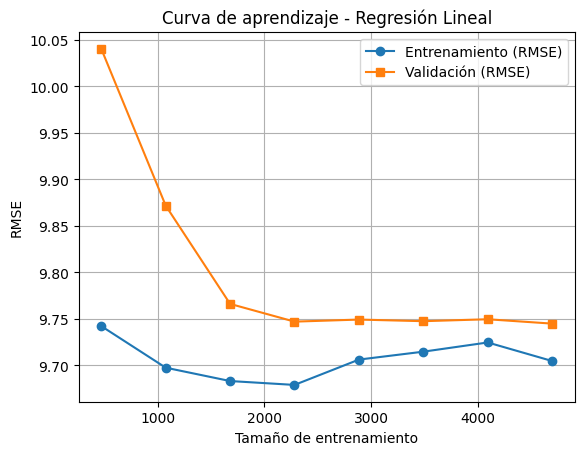

RMSE final - train: 9.705 | val: 9.745 | gap: 0.040
Brecha pequeña: el modelo generaliza razonablemente.
La métrica de validación aún mejora con más datos: probablemente se beneficia de más datos.


In [ ]:

train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(), X, y, cv=cv, scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=RANDOM_STATE
)

train_rmse = -train_scores
val_rmse = -val_scores
train_mean = train_rmse.mean(axis=1)
val_mean = val_rmse.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label="Entrenamiento (RMSE)")
plt.plot(train_sizes, val_mean, marker='s', label="Validación (RMSE)")
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("RMSE")
plt.title("Curva de aprendizaje - Regresión Lineal")
plt.legend()
plt.grid(True)
plt.show()


gap = val_mean[-1] - train_mean[-1]
print(f"RMSE final - train: {train_mean[-1]:.3f} | val: {val_mean[-1]:.3f} | gap: {gap:.3f}")


## 6. Modelo no lineal: KNN (+ validación cruzada y curva de validación para *k*)

Mejor k: 7
Mejor RMSE CV: 6.326814372605749


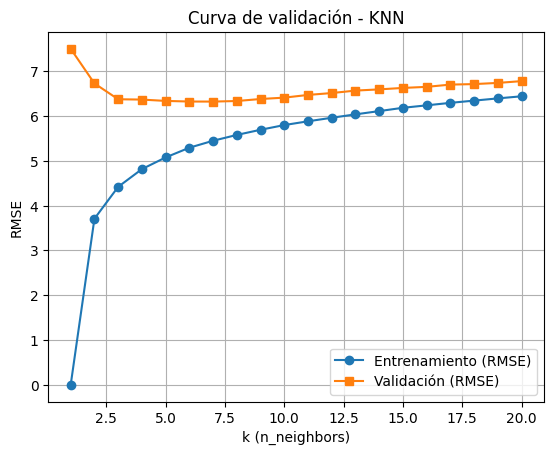

In [11]:

pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

param_grid = {"knn__n_neighbors": list(range(1, 21))}
gcv_knn = GridSearchCV(pipe_knn, param_grid, scoring="neg_root_mean_squared_error", cv=cv)
gcv_knn.fit(X, y)

print("Mejor k:", gcv_knn.best_params_["knn__n_neighbors"])
print("Mejor RMSE CV:", -gcv_knn.best_score_)

# Curva de validación (k de 1 a 20)
param_range = np.arange(1, 21)
train_scores, val_scores = validation_curve(
    pipe_knn, X, y, param_name="knn__n_neighbors", param_range=param_range,
    cv=cv, scoring="neg_root_mean_squared_error"
)
train_rmse = -train_scores
val_rmse = -val_scores
train_mean = train_rmse.mean(axis=1)
val_mean = val_rmse.mean(axis=1)

plt.figure()
plt.plot(param_range, train_mean, marker='o', label="Entrenamiento (RMSE)")
plt.plot(param_range, val_mean, marker='s', label="Validación (RMSE)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("RMSE")
plt.title("Curva de validación - KNN")
plt.legend()
plt.grid(True)
plt.show()


## 7. Otro modelo no lineal: SVR (RBF) (+ validación cruzada y curva de validación de hiperparámetros)

Mejores hiperparámetros RF: {'rf__max_depth': 20, 'rf__n_estimators': 200}
Mejor RMSE CV RF: 1.7890523701210306


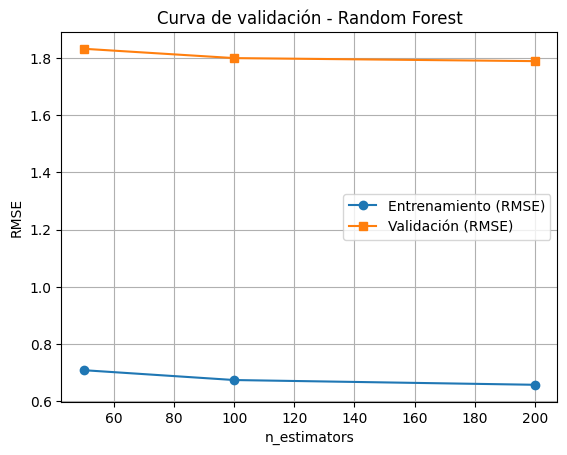

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ("scaler", StandardScaler()),  
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [None, 5, 10, 20]
}

gcv_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring="neg_root_mean_squared_error", cv=cv)
gcv_rf.fit(X, y)

print("Mejores hiperparámetros RF:", gcv_rf.best_params_)
print("Mejor RMSE CV RF:", -gcv_rf.best_score_)

# Curva de validación respecto a n_estimators (con max_depth óptimo)
best_max_depth = gcv_rf.best_params_["rf__max_depth"]
param_range_n = [50, 100, 200]

train_scores_n, val_scores_n = validation_curve(
    pipe_rf.set_params(rf__max_depth=best_max_depth), X, y,
    param_name="rf__n_estimators", param_range=param_range_n,
    cv=cv, scoring="neg_root_mean_squared_error"
)
train_rmse_n = -train_scores_n
val_rmse_n = -val_scores_n
train_mean_n = train_rmse_n.mean(axis=1)
val_mean_n = val_rmse_n.mean(axis=1)

plt.figure()
plt.plot(param_range_n, train_mean_n, marker='o', label="Entrenamiento (RMSE)")
plt.plot(param_range_n, val_mean_n, marker='s', label="Validación (RMSE)")
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title("Curva de validación - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

- El modelo lineal fue adecuado para los datos? ¿Por qué?
RMSE Lineal (CV): 9.745
RMSE DummyRegressor (CV): 10.699
El modelo lineal mejora sustancialmente el baseline, por lo que es adecuado para los datos.

- ¿Qué variables resultaron más relevantes según la selección de features?
Número óptimo de variables: 12
Variables seleccionadas: age, test_time, Jitter(Abs), Jitter:PPQ5, Jitter:DDP, Shimmer:APQ3, Shimmer:APQ11, NHR, HNR, DFA, PPE, sex

- ¿Los modelos no lineales funcionaron mejor que el lineal? Explica.
El modelo KNN con k=7 es el mejor para este problema, ya que obtuvo el menor RMSE (6.327) en comparación con los modelos SVR (9.092) y lineal (9.745). Esto indica que KNN logra predecir el valor de `total_UPDRS` con mayor precisión, capturando mejor las relaciones no lineales presentes en los datos.

- ¿Qué aprendizajes generales obtienes al modelar este conjunto de datos con regresión?
La estandarización es clave para modelos basados en distancias (KNN) y para SVR.
La selección de variables puede reducir la varianza y mejorar interpretabilidad sin sacrificar desempeño.
La curva de aprendizaje ayuda a diagnosticar si se necesitan más datos o regularización.
Comparar contra un baseline simple evita caer en optimismo injustificado.